The goal of this notebook is to determine the cumulative fraction of each basin that has been burned over the timeframe of the fire data.

In [1]:
# Import libraries
import geopandas as gpd

Here is the fire data from Matt:

In [2]:
# Import fire data
f=gpd.read_file("LAC_fires.geojson")

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


<AxesSubplot: >

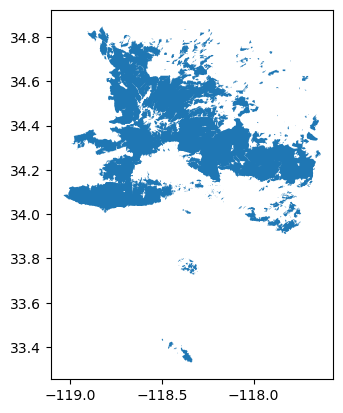

In [3]:
f.plot()

To import the hydrologic basins, I need a bounding box

In [4]:
bbox = (-118.9441,32.8065,-117.6447,34.8227) # Source: https://observablehq.com/@rdmurphy/u-s-county-bounding-boxes-by-state

In [9]:
b=gpd.read_file("../week5/data/BasinATLAS_Data_v10.gdb.zip", driver='FileGDB', layer='BasinATLAS_v10_lev12',bbox=bbox)

DriverError: '/vsizip/../week5/data/BasinATLAS_Data_v10.gdb.zip' does not exist in the file system, and is not recognized as a supported dataset name.

What I want to do now is use the `intersection` function in geopandas to find the area of each fire-to-basin overlap and sum those areas for each basin. For example, if a basin was 20% burned by one first and 15% burned by another, I want a number that scales with 35% -- regardless of whether or not the two fires themselves overlap (because, probably, they happened far enough apart... a more advanced version would add a recovery curve).

There is probably a better way to do this, but one method is to transform both geodataframes into lists with one basin (or fire) per list entry and then use "list comprehension" syntax to map the pairs through the intersection calculation:

In [ ]:
# Create a list "basins" with one entry per basin
basins = []
for i in list(range(0,b.shape[0])):
    basins.append([b.iloc[i]])

In [ ]:
# Create a list "fires" with one entry per fire
fires = []
for i in list(range(0,f.shape[0])):
    fires.append([f.iloc[i]])

In [ ]:
# Just to verity that each item retains geometry information:
fires[0][0]["geometry"]

In [ ]:
# Triplet of functions to aggregate intersections
def f1(a,b):
    return a[0]["geometry"].intersection(b[0]["geometry"]).area
def f2(b,aa):
    return sum([f1(a,b) for a in aa])
def f3(aa,bb):
    return [f2(b,aa) for b in bb]

In [ ]:
# Compute the area of fire intersection in each basin
i=f3(fires,basins)

Okay. `i` should be a list with one entry per basin, with the entry being the cumulative burned area. Let's make sure there is one entry per basin:

In [6]:
print(len(i))
print(len(basins))
print(b.shape[0])

NameError: name 'i' is not defined

Next, I want to assign each cumulative burned area to each basin:

In [7]:
b["burnt"] = i

NameError: name 'i' is not defined

Let's see if that worked!

In [8]:
b.plot(column=b["burnt"])

NameError: name 'b' is not defined

Good -- the fires are in the hills!

What I want to do next is calculate for each basin the total area (and burnt area) in the basin and *upstream* of the basin. Basin on the network diagrams from last week, I know that there is no partitioning of upstream basins -- each basin ***U*** has exactly one downstream basin ***D***.

The basin data already have a column providing the immediate *downstream* basin for each basin. I need to add a column with the immediate *upstream* basin(s).

In [ ]:
# for each basin, find the immediate upstream basins
for basin in b:
    if basin["down"]!=0:
        b[b[“id”]==basin[“down”]][“up”].append(basin[“id”])

Now I can iteratively pull basins upstream of the upstream basins into a column of all upstream basins. The following is super inefficient computationally, but probably acceptable:

In [ ]:
# for each basin, find all upstream basins
for basin in b:
    for k in range(1,10):
        for j in basin[“up”]:
            basin[“up”].append(b[b[“id”]==j][“up”]

Now we can sum the total and burnt area in the upstream basins:

In [ ]:
# for each basins, find the fraction of watershed burnt
for basin in b:
    basin[“burnup”] = sum(b[b[“id”] = basin[“up”]][“burnt”])
    basin[“areaup”] = sum(b[b[“id”] = basin[“up”]].area)
    basin[“fburnt”] = (basin[“burnup”)+basin[“burnt”])/(basin[“areaup”]+basin.area)

Let's see if that worked!

In [ ]:
b.plot(column="fburnt")